# Predicting Flights Taxi-Out Time Using Deep Q-Learning
Data used in this project can be downloaded from https://www.transtats.bts.gov/Fields.asp. This project is inspired by this paper https://ieeexplore.ieee.org/document/7411275.

#### We will use the data from April 2019 in this code
Several challenges presented themselves when working with this data and trying to adapt the papers' approach namely:
- the extreme difficulty of calculating next states something which was not outlined in the paper at all. for this reason the reward function was modified to take into account the reward from the reward table and the penalty of wrong prediction instead of the maximum future rewarss
- Facing new states that have not been faced before. In the paper the author relied on matlabs functionality to handle this and did not discuss at at all. My approach is to build a neural network to predict the Q values for a state if it had not been faced before and then pass those Q values to the RL model.

![Model](image.png "Title")

In [1]:
import pandas as pd
from IPython.display import HTML
from datetime import datetime, date, time, timedelta
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data.csv').drop('Unnamed: 24', axis=1)
df = df[(df.CANCELLED == 0) & (df.DIVERTED == 0)].drop(
    ['CANCELLED', 'DIVERTED'], axis=1)

# Data Processing - creating the environment
X1 is going to be Taxi Out time, our target

In [2]:
df['x1'] = df['TAXI_OUT']

## Windowing
To be able to achieve the windowing described in the paper we will need to convert DEP_TIME and ARR_TIME into a python datetime object. We will also use the date from FL_DATE

In [3]:
def time_converter(in_):
    in_date = in_[0]
    in_time = in_[1]
    in_time = str(in_time)
    if '.' in in_time:
        in_time = in_time[:-2]
    while len(str(in_time)) < 4:
        in_time = '0' + in_time
    if in_time[:2] == '24':
        in_time = '00' + in_time[2:]
    time_ = time(int(in_time[:2]), int(in_time[2:4]), 0)
    in_date = in_date.split('-')
    date_ = date(int(in_date[0]), int(in_date[1]), int(in_date[2]))
    return datetime.combine(date_, time_)


time_cols = ['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF',
             'WHEELS_ON', 'CRS_ARR_TIME', 'ARR_TIME', ]

for i, col in enumerate(time_cols):
    df[col] = df[['FL_DATE', col]].apply(time_converter, axis=1)
    print(f"{round(100*(i+1)/len(time_cols),2)}% done.")

16.67% done.
33.33% done.
50.0% done.
66.67% done.
83.33% done.
100.0% done.


The function get_bounds will calculate the bounds of each window, +-20 minutes from the flight being considered.
after that airplane_counter function was created to calculate the number of departure aircrafts sharing the runway with the aircraft being considered (x2). a few helper functions are created to track the progress of the function because it's a very lengthy calculation.

In [4]:
def get_bounds(in_time):
    time_d = timedelta(minutes=20)
    return (in_time - time_d),  (in_time + time_d)


def window_func(TIME, variable, df):
    lower_bound, upper_bound = get_bounds(TIME)
    df_ = df[(df[variable] >= lower_bound) & (df[variable] <=
                                              upper_bound)].copy()
    count_airplanes = len(df_) - 1
    return count_airplanes


def pct_tracker(to_be_done):
    done = 0
    count = 0
    while True:
        yield
        done += 1
        count += 1
        if done > to_be_done:
            done -= to_be_done
        if (count >= to_be_done * 0.02):
            count = 0
            pct = round((float(done) / float(to_be_done)) * 100, 2)
            print(f"{pct}% done.")


def track_progress(func=window_func, progress=pct_tracker(len(df))):
    def call_func(*args, **kwargs):
        progress.send(None)
        return func(*args, **kwargs)
    return call_func


def airplane_counter(func, variable, airport_type, list, add_cols=[]):
    listy = []
    sub_df = df.sort_values(by=[airport_type, variable])[
        [airport_type, variable] + add_cols].copy()
    for i, airport in enumerate(list):
        x = sub_df[sub_df[airport_type] == airport].copy()
        x['target'] = x[variable].apply(
            track_progress(func), args=([variable, x]))
        listy.append(x)
    series = pd.concat(listy).sort_values(by=[airport_type, variable]).target
    return series


df = df.sort_values(by=['ORIGIN', 'DEP_TIME']).copy()
origins = df.ORIGIN.unique().tolist()

x2 = airplane_counter(window_func, 'DEP_TIME', 'ORIGIN', origins)

2.0% done.
4.0% done.
6.0% done.
8.0% done.
10.0% done.
12.0% done.
14.0% done.
16.0% done.
18.0% done.
20.0% done.
22.0% done.
24.0% done.
26.0% done.
28.0% done.
30.0% done.
32.0% done.
34.0% done.
36.0% done.
38.0% done.
40.0% done.
42.0% done.
44.0% done.
46.0% done.
48.0% done.
50.0% done.
52.0% done.
54.0% done.
56.0% done.
58.0% done.
60.0% done.
62.0% done.
64.0% done.
66.0% done.
68.0% done.
70.0% done.
72.0% done.
74.0% done.
76.0% done.
78.0% done.
80.0% done.
82.0% done.
84.0% done.
86.0% done.
88.0% done.
90.0% done.
92.0% done.
94.0% done.
96.0% done.
98.0% done.


Similarly, we will calculate the number of arrival aircrafts sharing the runway with the aircraft being considered in the +-20 minutes window (x3)

In [5]:
df['x2'] = x2

df = df.sort_values(by=['DEST', 'ARR_TIME']).copy()
destinations = df.DEST.unique().tolist()

sub_df = df.sort_values(by=['DEST', 'ARR_TIME'])[
    ['DEST', 'ARR_TIME', 'ARR_DELAY']].copy()
dict_ = {dest: sub_df[sub_df['DEST'] == dest].copy() for dest in destinations}


def window_func_arr(in_):
    ORIGIN, TIME = in_[0], in_[1]
    lower_bound, upper_bound = get_bounds(TIME)
    df = dict_[ORIGIN]
    df_ = df[(df['ARR_TIME'] >= lower_bound) & (df['ARR_TIME'] <=
                                                upper_bound)].copy()
    count_airplanes = len(df_)
    return count_airplanes


df['x3'] = df[['ORIGIN', 'DEP_TIME']].apply(
    track_progress(window_func_arr), axis=1)

0.01% done.
2.01% done.
4.01% done.
6.01% done.
8.01% done.
10.01% done.
12.01% done.
14.01% done.
16.01% done.
18.01% done.
20.01% done.
22.01% done.
24.01% done.
26.01% done.
28.01% done.
30.01% done.
32.01% done.
34.01% done.
36.01% done.
38.01% done.
40.01% done.
42.01% done.
44.01% done.
46.01% done.
48.01% done.
50.01% done.
52.01% done.
54.01% done.
56.01% done.
58.01% done.
60.01% done.
62.01% done.
64.01% done.
66.01% done.
68.01% done.
70.01% done.
72.01% done.
74.01% done.
76.01% done.
78.01% done.
80.01% done.
82.01% done.
84.01% done.
86.01% done.
88.01% done.
90.01% done.
92.01% done.
94.01% done.
96.01% done.
98.01% done.


-we will calculate the average taxi out time for each airoprt (x4)

-We will also define a function to check if the flight is or is not during peak time (x5)

-we will take (x6) to be air time and we will take (x7) to be taxi in

In [6]:
def is_peak(dep_time):
    dep_time = dep_time.time()
    if (dep_time >= time(4, 0) and (dep_time <= time(16, 0))):
        return 1
    else:
        return 2


dict_averages={origin: df[df.ORIGIN == origin]
                 ['TAXI_OUT'].mean() for origin in origins}


def avg_taxi_out(origin, dict=dict_averages):
    return dict[origin]


df['x4']=df.ORIGIN.apply(avg_taxi_out)

df['x5']=df.DEP_TIME.apply(is_peak)

df['x6']=df.AIR_TIME

df['x7']=df.TAXI_IN

df.to_csv('snapshot.csv', index=False)

-we will define x* as the number of late aircrafts sharing the runway with the aircraft being considered in the time window

In [7]:
def late_to_leave(TIME, variable, df):
    lower_bound, upper_bound=get_bounds(TIME)
    df_=df[(df[variable] >= lower_bound) & (df[variable] <=
                                              upper_bound) & ((df['DEP_DELAY'] < -15) | (df['DEP_DELAY'] > 15))].copy()
    count_airplanes=len(df_)
    return count_airplanes

x8=airplane_counter(late_to_leave, 'DEP_TIME', 'ORIGIN',
                    origins, add_cols=['DEP_DELAY'])

df['x8']=x8

0.01% done.
2.01% done.
4.01% done.
6.01% done.
8.01% done.
10.01% done.
12.01% done.
14.01% done.
16.01% done.
18.01% done.
20.01% done.
22.01% done.
24.01% done.
26.01% done.
28.01% done.
30.01% done.
32.01% done.
34.01% done.
36.01% done.
38.01% done.
40.01% done.
42.01% done.
44.01% done.
46.01% done.
48.01% done.
50.01% done.
52.01% done.
54.01% done.
56.01% done.
58.01% done.
60.01% done.
62.01% done.
64.01% done.
66.01% done.
68.01% done.
70.01% done.
72.01% done.
74.01% done.
76.01% done.
78.01% done.
80.01% done.
82.01% done.
84.01% done.
86.01% done.
88.01% done.
90.01% done.
92.01% done.
94.01% done.
96.02% done.
98.02% done.


x9 is the number of late arriving aircrafts on the runway in the time window

In [8]:
def late_to_arrive(in_):
    ORIGIN, TIME=in_[0], in_[1]
    lower_bound, upper_bound=get_bounds(TIME)
    df=dict_[ORIGIN]
    df_=df[(df['ARR_TIME'] >= lower_bound) & (df['ARR_TIME'] <=
                                                upper_bound) & ((df['ARR_DELAY'] < -15) | (df['ARR_DELAY'] > 15))].copy()
    count_airplanes=len(df_)
    return count_airplanes

df['x9']=df[['ORIGIN', 'DEP_TIME']].apply(
    track_progress(late_to_arrive), axis=1)

df[['ORIGIN', 'DEP_TIME'] +
    ['x' + str(i) for i in range(1, 10)]].to_csv('variables.csv', index=False)

work_df=df[['ORIGIN', 'DEP_TIME'] +
    ['x' + str(i) for i in range(1, 10)]]

0.02% done.
2.02% done.
4.02% done.
6.02% done.
8.02% done.
10.02% done.
12.02% done.
14.02% done.
16.02% done.
18.02% done.
20.02% done.
22.02% done.
24.02% done.
26.02% done.
28.02% done.
30.02% done.
32.02% done.
34.02% done.
36.02% done.
38.02% done.
40.02% done.
42.02% done.
44.02% done.
46.02% done.
48.02% done.
50.02% done.
52.02% done.
54.02% done.
56.02% done.
58.02% done.
60.02% done.
62.02% done.
64.02% done.
66.02% done.
68.02% done.
70.02% done.
72.02% done.
74.02% done.
76.02% done.
78.02% done.
80.02% done.
82.02% done.
84.02% done.
86.02% done.
88.02% done.
90.02% done.
92.02% done.
94.02% done.
96.02% done.
98.02% done.


Finally we will discretize our environment variables and with that our environment will be complete. our target x1 is going to be descritized into 5 bins

In [2]:
work_df=pd.read_csv('variables.csv')
work_df['DEP_TIME']=pd.to_datetime(work_df['DEP_TIME'])
print('non discretized environment variables')
work_df.iloc[:10,:]

non discretized environment variables


,ORIGIN,DEP_TIME,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,SFB,2019-04-01 06:58:00,15.0,7,0,13.801970,1,127.0,4.0,6,0
1,CLT,2019-04-01 09:46:00,27.0,33,28,21.445305,1,68.0,5.0,9,21
2,DTW,2019-04-01 10:09:00,18.0,39,16,17.244655,1,62.0,4.0,13,15
3,ATL,2019-04-01 10:39:00,11.0,58,42,15.761485,1,95.0,3.0,18,22
4,PHL,2019-04-01 12:47:00,14.0,22,9,21.666012,1,15.0,4.0,3,4
5,SFB,2019-04-01 12:13:00,13.0,1,3,13.801970,1,120.0,4.0,1,1
6,ORD,2019-04-01 13:56:00,33.0,65,44,21.773309,1,84.0,5.0,20,20
7,DTW,2019-04-01 15:40:00,21.0,42,22,17.244655,1,61.0,3.0,9,13
8,ATL,2019-04-01 15:49:00,15.0,37,53,15.761485,1,100.0,4.0,10,12
9,CLT,2019-04-01 16:24:00,19.0,52,19,21.445305,2,74.0,6.0,7,10


In [3]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer=KBinsDiscretizer(n_bins=5, encode='ordinal')
work_df['x1']=discretizer.fit_transform(
    work_df['x1'].to_numpy().reshape(-1, 1))

discretizer2=KBinsDiscretizer(n_bins=10, encode='ordinal')

for i in range(2, 10):
    work_df['x' + str(i)]=discretizer2.fit_transform(
        work_df['x' + str(i)].to_numpy().reshape(-1, 1))
print('Discretized env variables')
work_df.iloc[:10,:]

Discretized env variables


,ORIGIN,DEP_TIME,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,SFB,2019-04-01 06:58:00,2.0,3.0,0.0,2.0,0.0,7.0,2.0,4.0,0.0
1,CLT,2019-04-01 09:46:00,4.0,8.0,7.0,8.0,0.0,3.0,3.0,5.0,7.0
2,DTW,2019-04-01 10:09:00,3.0,8.0,5.0,6.0,0.0,2.0,2.0,5.0,6.0
3,ATL,2019-04-01 10:39:00,1.0,9.0,8.0,4.0,0.0,5.0,1.0,5.0,7.0
4,PHL,2019-04-01 12:47:00,2.0,7.0,4.0,8.0,0.0,0.0,2.0,3.0,3.0
5,SFB,2019-04-01 12:13:00,2.0,1.0,1.0,2.0,0.0,6.0,2.0,1.0,1.0
6,ORD,2019-04-01 13:56:00,4.0,9.0,8.0,9.0,0.0,4.0,3.0,5.0,7.0
7,DTW,2019-04-01 15:40:00,4.0,8.0,7.0,6.0,0.0,2.0,1.0,5.0,6.0
8,ATL,2019-04-01 15:49:00,2.0,8.0,8.0,4.0,0.0,5.0,2.0,5.0,6.0
9,CLT,2019-04-01 16:24:00,3.0,9.0,6.0,8.0,0.0,3.0,4.0,5.0,5.0


### Making the train and validation datasets
we will take the first three weeks of april as the training dataset and the last week as the validation dataset

In [4]:
train_df=work_df[work_df.DEP_TIME < datetime.combine(
    date(2019, 4, 24), time(0, 0, 0))]

validation_df=work_df[work_df.DEP_TIME >=
    datetime.combine(date(2019, 4, 24), time(0, 0, 0))]

train_env=train_df[['x' + str(i) for i in range(1, 10)]
                              ].to_numpy()

validation_env=validation_df[['x' + str(i) for i in range(1, 10)]
                              ].to_numpy()

### Making the rewards table (P)
the rewards table is going to be made so that it will have the value of three for the correct action and zero for all other actions

### Encoding states
each state vector will be encoded to byte code to help us look it up in later steps.

All of the status will be stored in a list named real_states

Finally we will initialize the Q table

In [5]:
import numpy as np
np.frombuffer(train_env[0].tobytes())
states_available=list(set([(i.tobytes(), i[0]) for i in train_env]))

from random import randrange, uniform

def reward_initializer(label):
    label=int(label)
    listy=[0 for i in range(5)]
    reward=3
    listy[label]=reward
    label_=label
    while True:
        try:
            label_ += 1
            listy[label_]=uniform(0, 1)
        except IndexError:
            break
    label_=label
    reward=3
    while True:
        try:
            label_ -= 1
            if label_ < 0:
                break
            listy[label_]=uniform(0, 1)
        except IndexError:
            break
    return listy

P={s[0]: reward_initializer(s[1]) for s in states_available}
import numpy as np
q_table={s[0]: np.asarray([0, 0, 0, 0, 0]) for s in states_available}
states=list(P.keys())
real_states=[np.frombuffer(i) for i in states]

To fill the Q table we are going to use the following values for alpha, gamma and epsilon. wwe're going to iterate 25 times over each state to populate its corresponding Q table record

In [6]:
print('Sample of P')
{key:value for key,value in list(P.items())[0:5]}

Sample of P


{b'\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00"@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x18@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x10@': [0.6706975067655605,
  0.9192702944641356,
  0.08005256218749413,
  0.7944636545570759,
  3],
 b'\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00\x1c@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x18@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x18@': [0.030056077440060225,
  0.2478930912198971,
  0.44397333582370924,
  0.02285937405431515,
  3],
 b'\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x00\x00\x00\x00\x00@': [0.34801746

In [7]:
alpha=0.4
gamma=0.6
epsilon=0.65

for i, state in enumerate(train_env):
    q=[0, 0, 0, 0, 0]
    for _ in range(25):
        state_encoded=state.tobytes()
        if uniform(0, 1) < epsilon:
            action=randrange(5)
        else:
            action=np.argmax(q_table[state_encoded])
        reward=P[state_encoded][action]
        old_value=q_table[state_encoded][action]
        new_value=(1 - alpha) * old_value + alpha *\
                   (reward - gamma * (action - state[0])**2)
        q[action]=new_value
    q_table[state_encoded]=q
    if i % 9949 == 0:
        print(f"{round((i+1)*100/len(train_env),2)}%")

0.0%
1.99%
3.99%
5.98%
7.97%
9.97%
11.96%
13.95%
15.95%
17.94%
19.93%
21.92%
23.92%
25.91%
27.9%
29.9%
31.89%
33.88%
35.88%
37.87%
39.86%
41.86%
43.85%
45.84%
47.84%
49.83%
51.82%
53.82%
55.81%
57.8%
59.79%
61.79%
63.78%
65.77%
67.77%
69.76%
71.75%
73.75%
75.74%
77.73%
79.73%
81.72%
83.71%
85.71%
87.7%
89.69%
91.69%
93.68%
95.67%
97.66%
99.66%


In [8]:
print("sample of q_table")
{key:value for key,value in list(q_table.items())[0:5]}

sample of q_table


{b'\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00"@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x18@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x10@': [-3.571720997293776,
  -1.7922918822143457,
  -0.9279789751250024,
  0.07778546182283037,
  1.2000000000000002],
 b'\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00\x1c@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x18@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x18@': [-6.124764110438361,
  -3.297348421619266,
  -1.251857065072826,
  -0.3693700006052383,
  1.9200000000000004],
 b'\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x

We will then take x2 to x9 and scale them for use in our neural network and we are going to separate x1, which is the target. We will also scale q_table

In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(
    np.vstack([train_env[:, 1:], validation_env[:, 1:]]))
train_X=scaler.transform(np.asarray(real_states)[:, 1:])
validation_X=scaler.transform(validation_env[:, 1:])
train_y=train_env[:, 0]
validation_y=validation_env[:, 0]

np_q_table=np.array(list(q_table.values()))
np_q_table=StandardScaler().fit_transform(np_q_table)

### The neural network
Next we will build a neural network that was described in this book (Geron A. Hands-on Machine Learning with...2ed 2019) this network is very robust in mutiple regression problems.

In [12]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
from tensorflow import keras

def builder(neurons=40, dropout_rate=.6, n_layer=2, momentum=.8, learn_rate=1e-4):
    input_l=keras.layers.Input(shape=(8,))
    drop1=keras.layers.Dropout(rate=dropout_rate)(input_l)
    hidden_layers=[drop1]
    n=0
    for i in range(n_layer):
        hidden_layers.append(keras.layers.Dense(
            neurons, activation='selu', kernel_initializer='lecun_normal')(hidden_layers[n]))
        n_neurons=int(np.ceil(neurons / 2))
        n += 1
        hidden_layers.append(keras.layers.Dropout(
            rate=dropout_rate)(hidden_layers[n]))
        n += 1
    concat=keras.layers.Concatenate()([hidden_layers[n - 1], input_l])
    output=keras.layers.Dense(5, activation='selu')(concat)
    model=keras.Model(inputs=[input_l], outputs=[output])
    model.compile(loss="mse", optimizer=keras.optimizers.SGD(
        lr=learn_rate, momentum=momentum, nesterov=True))
    return model

We will then use RandomizedSearchCV to find the optimal parameter for this model

In [13]:
from sklearn.model_selection import RandomizedSearchCV

neurons=[40, 80, 160]
learn_rate=[1e-3, 1e-4]
momentum=[.6, .8]
dropout_rate=[.2, .4, .6]
n_layer=[2, 3, 4]
param_grid=dict(neurons=neurons, learn_rate=learn_rate,
                momentum=momentum, dropout_rate=dropout_rate, n_layer=n_layer)

model_to_optimize=keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=builder, verbose=0)

rnd_search_cv=RandomizedSearchCV(
    estimator=model_to_optimize, param_distributions=param_grid, n_iter=25, cv=3, verbose=10)

rnd_search_cv.fit(train_X, np_q_table, epochs=50, batch_size=512,
                  validation_split=.2, callbacks=[early_stop_CB])

print(rnd_search_cv.best_params_)

cv_results_df=pd.DataFrame(rnd_search_cv.cv_results_)
cv_results_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] neurons=160, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  neurons=160, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.2, score=-0.883, total=  17.9s
[CV] neurons=160, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


[CV]  neurons=160, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.2, score=-0.883, total=  18.3s
[CV] neurons=160, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.1s remaining:    0.0s


[CV]  neurons=160, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.2, score=-0.883, total=  18.6s
[CV] neurons=40, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   54.8s remaining:    0.0s


[CV]  neurons=40, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.6, score=-0.888, total=  18.8s
[CV] neurons=40, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV]  neurons=40, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.6, score=-0.889, total=  18.4s
[CV] neurons=40, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.6 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV]  neurons=40, n_layer=2, momentum=0.6, learn_rate=0.001, dropout_rate=0.6, score=-0.888, total=  18.6s
[CV] neurons=80, n_layer=4, momentum=0.8, learn_rate=0.001, dropout_rate=0.2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s


[CV]  neurons=80, n_layer=4, momentum=0.8, learn_rate=0.001, dropout_rate=0.2, score=-0.889, total=  13.3s
[CV] neurons=80, n_layer=4, momentum=0.8, learn_rate=0.001, dropout_rate=0.2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.1min remaining:    0.0s


[CV]  neurons=80, n_layer=4, momentum=0.8, learn_rate=0.001, dropout_rate=0.2, score=-0.887, total=  23.0s
[CV] neurons=80, n_layer=4, momentum=0.8, learn_rate=0.001, dropout_rate=0.2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s


[CV]  neurons=80, n_layer=4, momentum=0.8, learn_rate=0.001, dropout_rate=0.2, score=-0.886, total=  24.6s
[CV] neurons=80, n_layer=2, momentum=0.6, learn_rate=0.0001, dropout_rate=0.6 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.9min remaining:    0.0s


[CV]  neurons=80, n_layer=2, momentum=0.6, learn_rate=0.0001, dropout_rate=0.6, score=-0.904, total=  19.3s
[CV] neurons=80, n_layer=2, momentum=0.6, learn_rate=0.0001, dropout_rate=0.6 
[CV]  neurons=80, n_layer=2, momentum=0.6, learn_rate=0.0001, dropout_rate=0.6, score=-0.908, total=  18.3s
[CV] neurons=80, n_layer=2, momentum=0.6, learn_rate=0.0001, dropout_rate=0.6 
[CV]  neurons=80, n_layer=2, momentum=0.6, learn_rate=0.0001, dropout_rate=0.6, score=-0.908, total=  18.4s
[CV] neurons=160, n_layer=4, momentum=0.6, learn_rate=0.0001, dropout_rate=0.2 
[CV]  neurons=160, n_layer=4, momentum=0.6, learn_rate=0.0001, dropout_rate=0.2, score=-0.899, total=  23.0s
[CV] neurons=160, n_layer=4, momentum=0.6, learn_rate=0.0001, dropout_rate=0.2 
[CV]  neurons=160, n_layer=4, momentum=0.6, learn_rate=0.0001, dropout_rate=0.2, score=-0.898, total=  22.7s
[CV] neurons=160, n_layer=4, momentum=0.6, learn_rate=0.0001, dropout_rate=0.2 
[CV]  neurons=160, n_layer=4, momentum=0.6, learn_rate=0.000

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 26.7min finished


{'neurons': 160, 'n_layer': 2, 'momentum': 0.8, 'learn_rate': 0.001, 'dropout_rate': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_neurons,param_n_layer,param_momentum,param_learn_rate,param_dropout_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,16.536325,0.357839,1.717971,0.114103,160,2,0.6,0.001,0.2,"{'neurons': 160, 'n_layer': 2, 'momentum': 0.6...",-0.882800,-0.883241,-0.882879,-0.882973,0.000192,2
1,16.942949,0.210250,1.666896,0.059093,40,2,0.6,0.001,0.6,"{'neurons': 40, 'n_layer': 2, 'momentum': 0.6,...",-0.888247,-0.888642,-0.888447,-0.888445,0.000162,10
2,18.600266,4.942481,1.685216,0.019723,80,4,0.8,0.001,0.2,"{'neurons': 80, 'n_layer': 4, 'momentum': 0.8,...",-0.889349,-0.887007,-0.886343,-0.887566,0.001289,5
3,17.051575,0.446735,1.613906,0.025097,80,2,0.6,0.0001,0.6,"{'neurons': 80, 'n_layer': 2, 'momentum': 0.6,...",-0.903832,-0.908489,-0.908040,-0.906787,0.002098,25
4,21.855701,0.997928,1.729167,0.032356,160,4,0.6,0.0001,0.2,"{'neurons': 160, 'n_layer': 4, 'momentum': 0.6...",-0.899377,-0.898157,-0.896689,-0.898074,0.001099,20
5,18.005790,0.903024,1.955860,0.328167,80,2,0.6,0.001,0.6,"{'neurons': 80, 'n_layer': 2, 'momentum': 0.6,...",-0.887616,-0.888123,-0.888181,-0.887974,0.000254,7
6,22.123062,0.105671,1.792026,0.006208,160,4,0.8,0.0001,0.4,"{'neurons': 160, 'n_layer': 4, 'momentum': 0.8...",-0.894896,-0.892153,-0.891941,-0.892997,0.001346,16
7,17.488663,0.085727,1.732671,0.059987,80,2,0.6,0.0001,0.2,"{'neurons': 80, 'n_layer': 2, 'momentum': 0.6,...",-0.901937,-0.899832,-0.903123,-0.901631,0.001361,22
8,21.982194,0.354545,1.689463,0.021146,80,4,0.8,0.0001,0.4,"{'neurons': 80, 'n_layer': 4, 'momentum': 0.8,...",-0.893142,-0.891684,-0.894107,-0.892977,0.000996,15
9,19.876271,1.367879,1.765060,0.111680,40,3,0.6,0.001,0.2,"{'neurons': 40, 'n_layer': 3, 'momentum': 0.6,...",-0.886620,-0.888519,-0.886898,-0.887346,0.000837,4


We will then train our best model

Epoch 1/500
41/41 [==============================] - 0s 4ms/step - loss: 3.0040 - val_loss: 1.7528
Epoch 2/500
41/41 [==============================] - 0s 4ms/step - loss: 2.5205 - val_loss: 1.4058
Epoch 3/500
41/41 [==============================] - 0s 3ms/step - loss: 2.2814 - val_loss: 1.2402
Epoch 4/500
41/41 [==============================] - 0s 3ms/step - loss: 2.1485 - val_loss: 1.1557
Epoch 5/500
41/41 [==============================] - 0s 3ms/step - loss: 2.0649 - val_loss: 1.1095
Epoch 6/500
41/41 [==============================] - 0s 3ms/step - loss: 2.0063 - val_loss: 1.0827
Epoch 7/500
41/41 [==============================] - 0s 3ms/step - loss: 1.9683 - val_loss: 1.0659
Epoch 8/500
41/41 [==============================] - 0s 3ms/step - loss: 1.9298 - val_loss: 1.0549
Epoch 9/500
41/41 [==============================] - 0s 3ms/step - loss: 1.9036 - val_loss: 1.0467
Epoch 10/500
41/41 [==============================] - 0s 3ms/step - loss: 1.8777 - val_loss: 1.0402
Epoch 11/

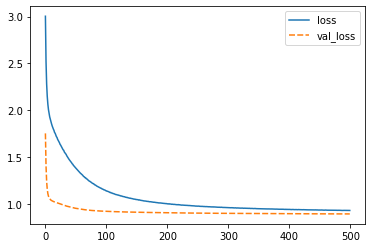

In [108]:
model = builder(neurons=160, dropout_rate=.4, n_layer=2, momentum=.8, learn_rate=1e-4)

model_trained=model.fit(
    train_X, np_q_table, epochs=500, batch_size=5000, validation_split=.4, callbacks=[early_stop_CB])

model.save('best_model.h5')

import seaborn as sns
sns.lineplot(data=pd.DataFrame(model_trained.history))

## Using the model
Finally we will define the make_prediction function which will encode the state then look it up in the q table. if the state was found, the optimal policy is followed, if not the NN estimates Q values based on which the RL model takes an action

In [109]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

Evaluating the model

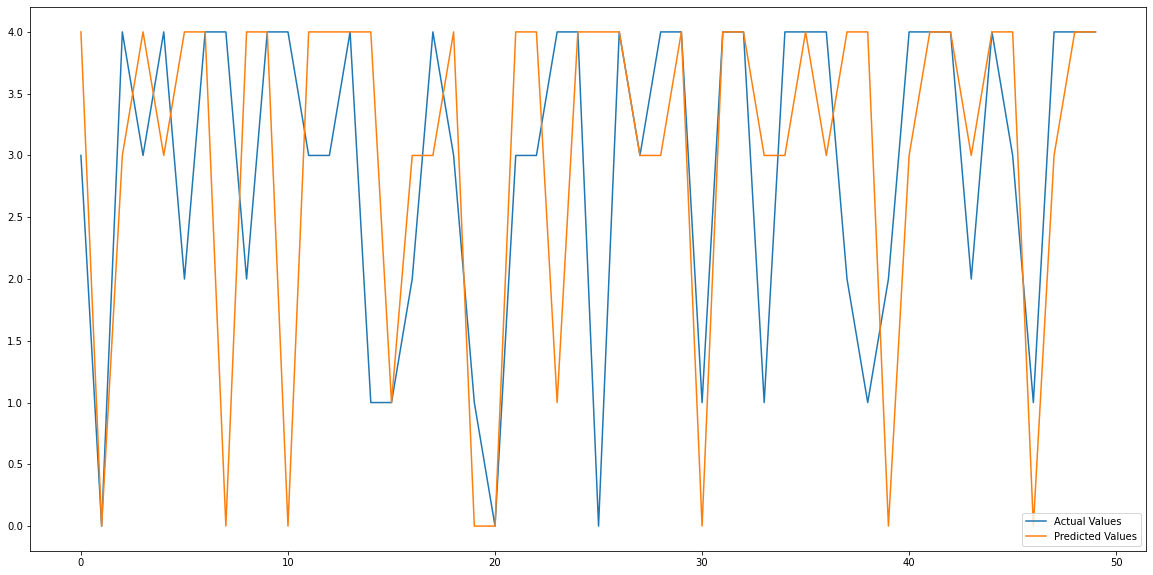

In [120]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

q_predict=model.predict(validation_X[:1000], batch_size=1)

predictions=[np.argmax(i) for i in q_predict]

def make_prediction(state):
    state_encoded=state.tobytes()
    try:
        action=np.argmax(q_table[state_encoded])
        return action
    except Exception as e:
        q_predict=model.predict(state.reshape(1, 8))
        action=np.argmax(q_predict)
        return action
    
y_predict=np.apply_along_axis(make_prediction, 1, validation_X[:50, :9])
y_true = validation_y[:50]

sns.lineplot(list(range(50)), y_true[:50],  label="Actual Values")
sns.lineplot(list(range(50)), y_predict[:50],  label="Predicted Values")

In [117]:
y_predict=np.apply_along_axis(make_prediction, 1, validation_X[:100, :9])
y_true = validation_y[:100]

from sklearn.metrics import mean_squared_error
print(f"The model's MSE score is {mean_squared_error(y_true, y_predict)}")

The model's MSE score is 1.84
